# Project iFood CRM - Data Advanced Analytics Business Case

![Teste](https://www.cora.com.br/blog/wp-content/uploads/elementor/thumbs/Imagem-Ifood-red-1-pqpti8fbo93e9dbvljmi9hm48xg4073mrqaq7898cg.png)

iFood is the lead food delivery app in Brazil, present in over a thousand cities.
Keeping a high customer engagement is key for growing and consolidating the company’s
position as the market leader.

Data Analysts working within the data team are constantly challenged to provide insights and
value to the company through open scope projects. This case intends to simulate that.
In this case, you are presented a sample dataset, that mocks metainformation on the customer
and on iFood campaign interactions with that customer.

It is your challenge to understand the data, find business opportunities & insights and to propose
any data driven action to optimize the campaigns results & generate value to the company.
This case aims to evaluate your Data skills and knowledge for two possible roles:

- Data Analyst Business:
    - Perform robust exploratory analysis, rich with business insights & data driven proposals
to add value to the company and have strong communication skills to influence the
decision making
- Data Advanced Analytics
    - Perform robust exploratory analysis, using advanced analytics tools and statistical
methods to generate data products to optimize business results (predictive & clustering
models, for example)


### About the dataset
The data set contains socio-demographic and firmographic features about 2.240 customers who
were contacted. Additionally, it contains a flag for those customers who responded the campaign,
by buying the product

### Goals of the Project

- Explore the data - you need to provide the marketing team a better understanding of the characteristics features of respodents;
- At least 3 important insights;
- Model a customer segmentation that can increase the campaign profit;
- Create a predictive model to maximize the profit of the next marketing campaign;
- Power Point to present the results.

### Deliverable
- Storytelling of Insights.
- Model that can be used by the business and marketing team.

### Data Source
https://github.com/ifood/ifood-data-business-analyst-test

### Solution Planning

Since the business case is composed by 3 parts, I will split the problem in 3 different notebooks to be well organized and structured. The goal of the data analysis notebook will be analyze the provided dataset and understand the data. Also,  it is necessary to create some hypothesis, validate it using exploratory data analysis and extract some actionable insights. The second part is using some methods to create cluster of clients according to the profile and use it to create some recommendations for the marketing campaign. It should increase the profit, since we are aiming specific clients. The last part will be the predictive model, joining the results generated by the clustering modelization, we can predict if the client will accept the next offer and then calculate the business impact based on the inputs of the dataset.

#### 1. Planning of Data Analysis [DONE]
- Business understanding and context
- Describe Data
- Hypothesis Creation
- Feature Engineering
- Filtering Variables
- Exploratory Data Analysis

#### 2. Planning of Clustering [DONE]
- Data Preparation
- Feature Selection
- Modeling Cluster
- Cluster Analysis
- Recommendations


#### 3. Planning of Predictive Model
- Data Preparation
- Feature Selection
- Machine Learning Modeling
- Hyper parameters Fine-Tunning
- Evaluation
- Business Impact


### Data Dictionary

![Data](images/metadata-table.PNG)

## Classification - Customer Propensity

## 0.0 Imports

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV

### 0.1 Helper Functions

In [195]:
def descriptive_analysis(numerical_df):
    # Function that calculate all the statistics measures for the dataset
    # Central tendency - Mean, median
    ct1 = pd.DataFrame(numerical_df.apply(np.mean)).T
    ct2 = pd.DataFrame(numerical_df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(numerical_df.apply(np.std)).T
    d2 = pd.DataFrame(numerical_df.apply(min)).T
    d3 = pd.DataFrame(numerical_df.apply(max)).T
    d4 = pd.DataFrame(numerical_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(numerical_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(numerical_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
    m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

    return m

In [196]:
def evaluate_models(model_list, X, y, cv = 5, threshold = 0.5):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    results_df = pd.DataFrame([], columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Validation Accuracy', 'Validation Precision', 'Validation Recall'])

    for name, model in model_list:

        train_accuracy = []
        train_precision  = []
        train_recall  = []

        val_accuracy = []
        val_precision = []
        val_recall = []

        for train_index, val_index in skf.split(X, y):

            X_train_fold = X.iloc[train_index, :]
            X_val_fold = X.iloc[val_index, :]

            y_train_fold = y.iloc[train_index]
            y_val_fold = y.iloc[val_index]

            model_pipe = Pipeline([
                                ('preprocessor', preprocessor),
                                ('selector', SequentialFeatureSelector(DecisionTreeClassifier())),
                                ('model', model)
                            ])
            
            model_pipe.fit(X_train_fold, y_train_fold)

            # Predict on the training and testing sets
            y_train_pred = model_pipe.predict_proba(X_train_fold)
            y_train_pred = (y_train_pred[:,1] > threshold).astype(int)
            y_val_pred = model_pipe.predict_proba(X_val_fold)
            y_val_pred = (y_val_pred[:,1] > threshold).astype(int)

            # Calculate the evaluation metrics for the training set
            train_accuracy.append(accuracy_score(y_train_fold, y_train_pred))
            train_precision.append(precision_score(y_train_fold, y_train_pred))
            train_recall.append(recall_score(y_train_fold, y_train_pred))

            # Calculate the evaluation metrics for the validation set
            val_accuracy.append(accuracy_score(y_val_fold, y_val_pred))
            val_precision.append(precision_score(y_val_fold, y_val_pred))
            val_recall.append(recall_score(y_val_fold, y_val_pred))

        model_metrics = [name, np.mean(train_accuracy), np.mean(train_precision), np.mean(train_recall), np.mean(val_accuracy), np.mean(val_precision), np.mean(val_recall)]

        results_df = results_df.append(pd.DataFrame([model_metrics], columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Validation Accuracy', 'Validation Precision', 'Validation Recall']), ignore_index=True)
        
    return results_df

In [197]:
def evaluate(y_true, y_pred_prob, threshold = 0.5):
    # convert probabilities to binary predictions
    y_pred = (y_pred_prob > threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC-AUC:", roc_auc)
    


### 1.0 Loading Data

In [198]:
df0 = pd.read_csv('../data/ml_project1_data.csv')

### 1.1 Rename Columns

In [199]:
old_columns = ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
               'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
               'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
               'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
               'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
               'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

lower_case = lambda x: x.lower()

new_columns = list(map(lower_case, old_columns))

df0.columns = new_columns

In [200]:
df0.head()

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,...,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,z_costcontact,z_revenue,response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


### 2.0 Missing Values

In [201]:
(df0.isna().sum() / len(df0))*100

id                     0.000000
year_birth             0.000000
education              0.000000
marital_status         0.000000
income                 1.071429
kidhome                0.000000
teenhome               0.000000
dt_customer            0.000000
recency                0.000000
mntwines               0.000000
mntfruits              0.000000
mntmeatproducts        0.000000
mntfishproducts        0.000000
mntsweetproducts       0.000000
mntgoldprods           0.000000
numdealspurchases      0.000000
numwebpurchases        0.000000
numcatalogpurchases    0.000000
numstorepurchases      0.000000
numwebvisitsmonth      0.000000
acceptedcmp3           0.000000
acceptedcmp4           0.000000
acceptedcmp5           0.000000
acceptedcmp1           0.000000
acceptedcmp2           0.000000
complain               0.000000
z_costcontact          0.000000
z_revenue              0.000000
response               0.000000
dtype: float64

Income has around 1% with NaN values. We need to replace this in the future.

### 2.1 Data Types

In [202]:
df0.dtypes

id                       int64
year_birth               int64
education               object
marital_status          object
income                 float64
kidhome                  int64
teenhome                 int64
dt_customer             object
recency                  int64
mntwines                 int64
mntfruits                int64
mntmeatproducts          int64
mntfishproducts          int64
mntsweetproducts         int64
mntgoldprods             int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
z_costcontact            int64
z_revenue                int64
response                 int64
dtype: object

In [203]:
df0['dt_customer'] = pd.to_datetime(df0['dt_customer'])

Only dt_customer was wrong, then we changed it to datetime even if we are not using now.

All the others statistics and exploratory analysis are in the crm_ifood_data_analysis.ipynb.

### 2.2 Checking Outliers 

Checking for outliers in a dataset is an essential step in data analysis because outliers can significantly affect the accuracy and reliability of our statistical analyses. They are data points that deviate significantly from the rest of the dataset, and they can be caused by errors in data collection, measurement, or recording. 

These extreme values can skew the results of statistical analyses, making them misleading or even invalid. It is possible to analyze these abnormalities through a box plot or even with the distribution of the data. In this case, the first one is chosen. Then, it's critical to perform this analysis and, if necessary, remove or correct them before performing any statistical analysis on a dataset.

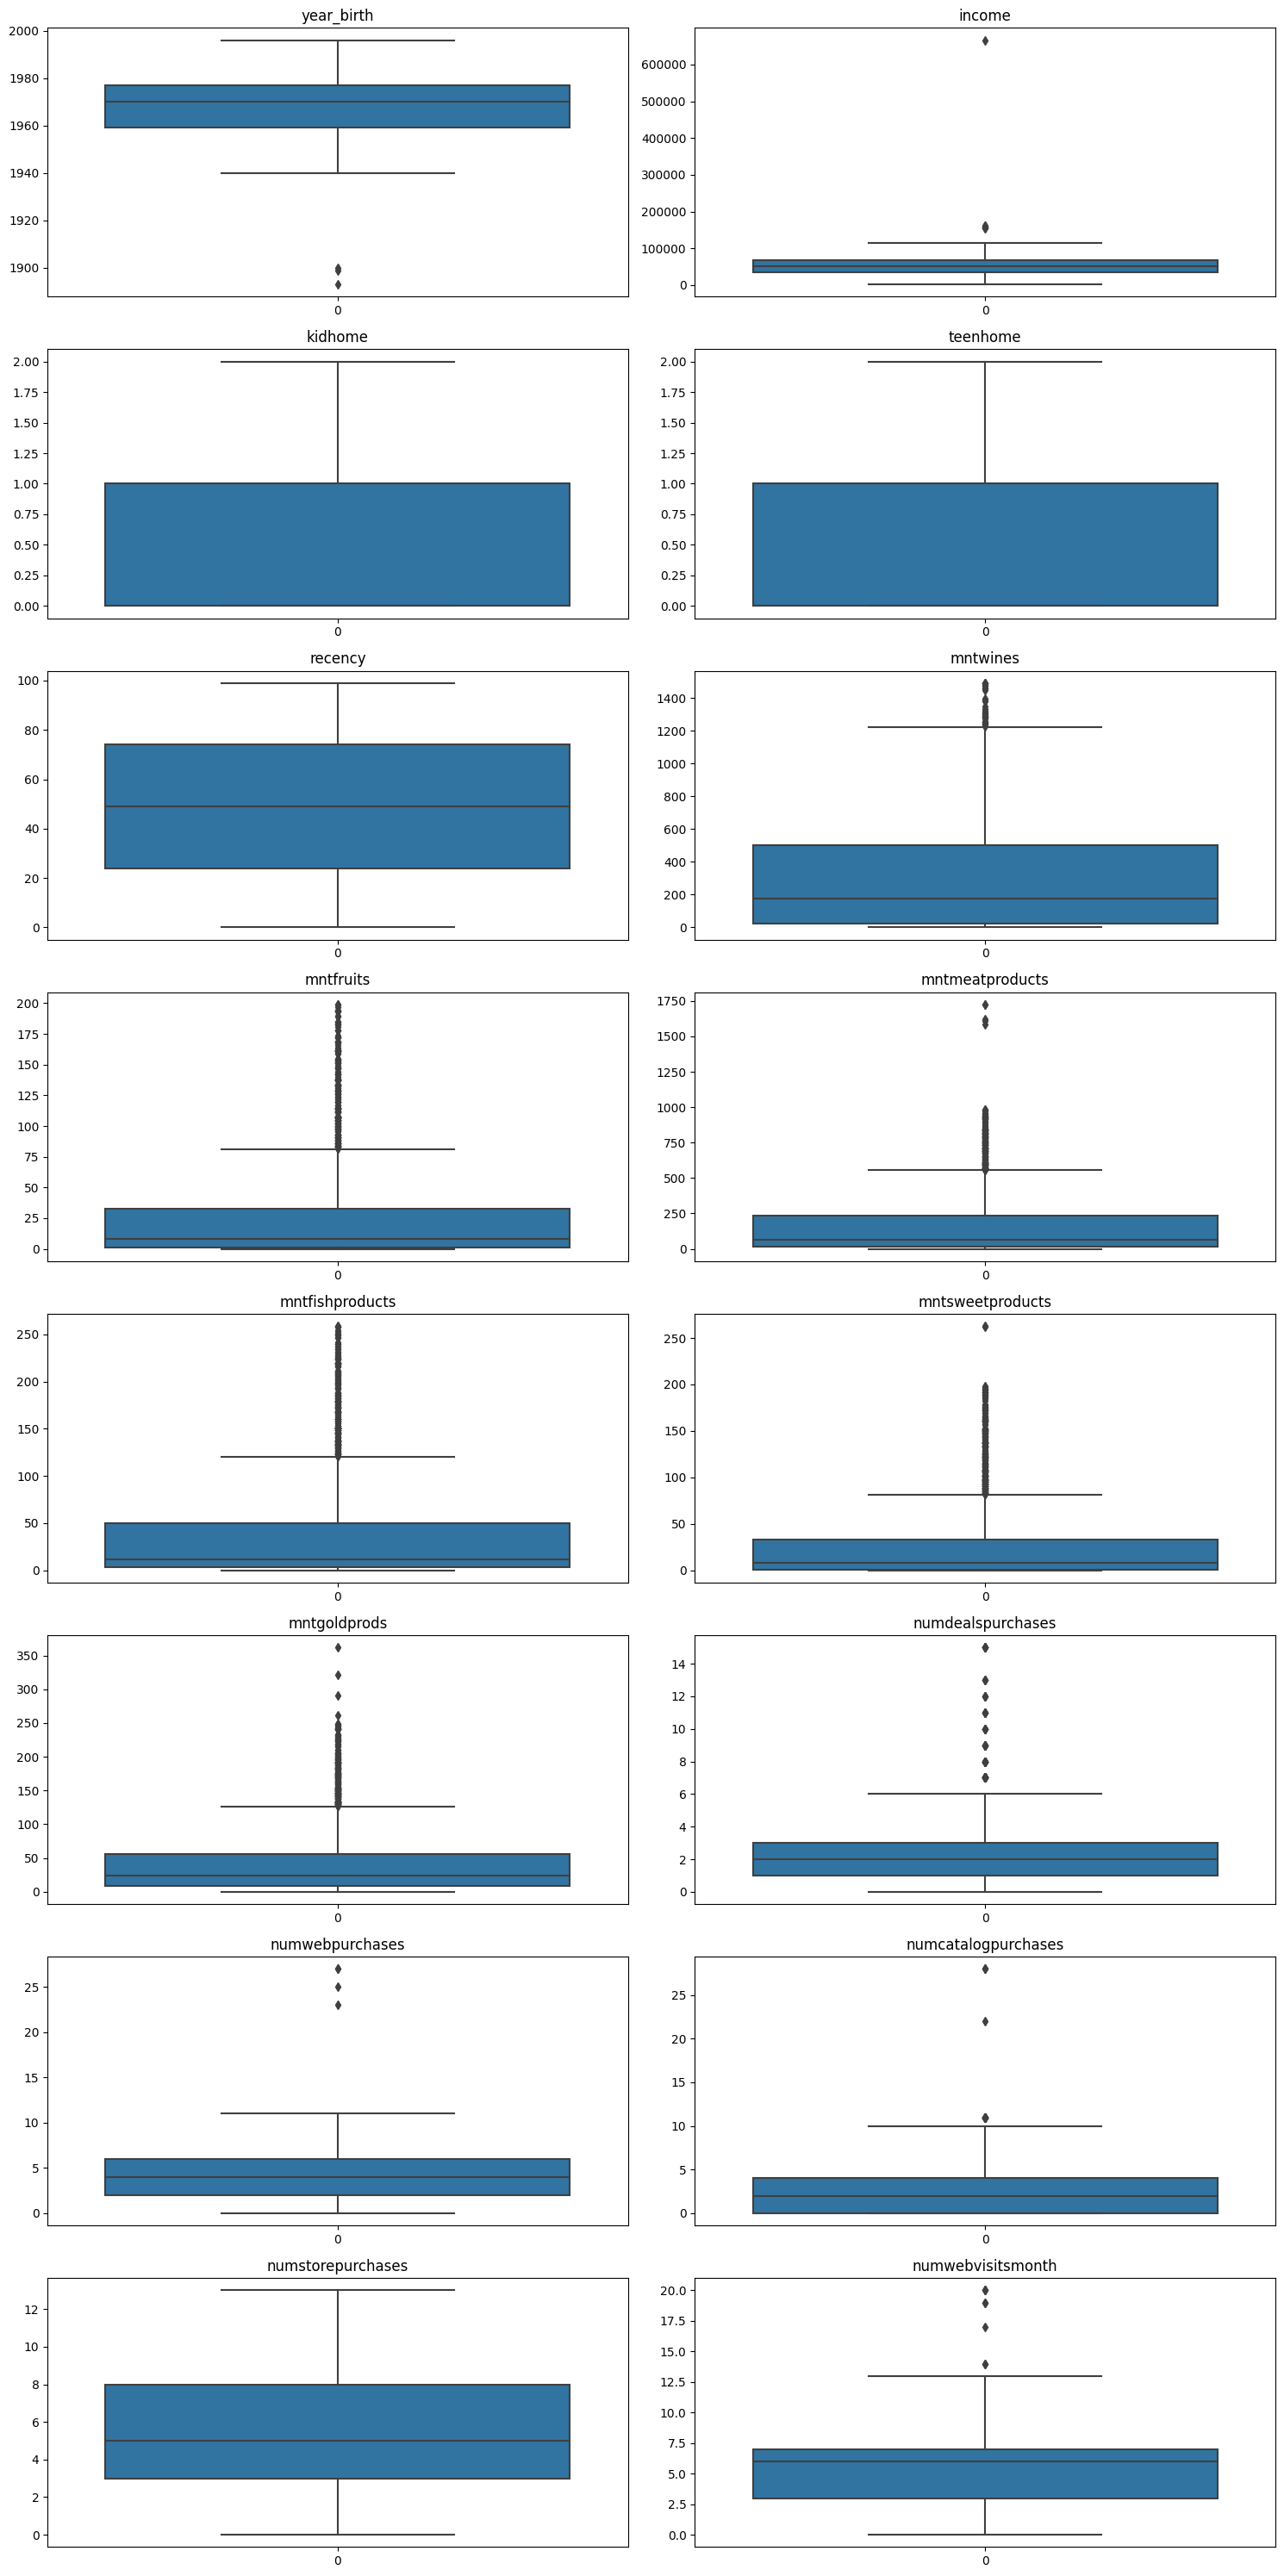

In [204]:
cols_to_check = ['year_birth','income','kidhome','teenhome','recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

plt.figure(1, figsize = (15,30))
for i,col in enumerate(cols_to_check):
    plt.subplot(8, 2, i+1)
    sns.boxplot(df0[col])
    plt.title(col)
    plt.tight_layout()
    

It's possible to see that that numstorepurchases, recency, kidhome and teenhome there are no outliers. The other columns must be treated if used in by any algorithm sensible to outliers.

### 2.3 Descriptive Statistics

In [205]:
num_vars = df0.select_dtypes(include = ['int64', 'float64'])
cat_vars = df0.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

#### Numerical Attributes

In [206]:
stat = descriptive_analysis(num_vars)
stat

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,id,5592.159821,5458.5,3245.937415,0.0,11191.0,11191.0,0.039832,-1.190028
1,year_birth,1968.805804,1970.0,11.981394,1893.0,1996.0,103.0,-0.349944,0.717464
2,income,52247.251354,NaN,25167.396174,1730.0,666666.0,664936.0,6.763487,159.636700
3,kidhome,0.444196,0.0,0.538278,0.0,2.0,2.0,0.635288,-0.779661
4,teenhome,0.506250,0.0,0.544417,0.0,2.0,2.0,0.407115,-0.986235
5,recency,49.109375,49.0,28.955987,0.0,99.0,99.0,-0.001987,-1.201897
6,mntwines,303.935714,173.5,336.522251,0.0,1493.0,1493.0,1.175771,0.598744
7,mntfruits,26.302232,8.0,39.764555,0.0,199.0,199.0,2.102063,4.050976
8,mntmeatproducts,166.950000,67.0,225.664984,0.0,1725.0,1725.0,2.083233,5.516724
9,mntfishproducts,37.525446,12.0,54.616784,0.0,259.0,259.0,1.919769,3.096461


- year_birth shows some insconsistency, since the minimum year is 1893, which leads to an age of more then 100 years. Also, the average age is about 44 years (assuming the dataset is from 2014).
- income of $1730 (yearly) is unrealistic for a family, maybe this is a inconsistency or students that lives alone but receive from parents. 
- kidhome and teenhome is limited to 2 childrens.
- The number of days since the last purchase (recency) is about 49 days, on average.
- The mean amount spent with wines and meat is greater than the other products (more expensive).
- People use to buy, on average, almost the same frequency on web or at the store.
- The sucess rate of the past campaigns (from 1 to 5) is about 7% except for the second one, which is 1.3%.
- The complain rate is less than 1%.
- z_costcontact and z_revenue does not have any information.
- The sucess rate of the last campaign (7th or response) is about 15%.

#### Categorical Attributes

In [207]:
cat_vars['education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [208]:
cat_vars['marital_status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [209]:
cat_vars['marital_status'].value_counts(normalize=True)*100

Married     38.571429
Together    25.892857
Single      21.428571
Divorced    10.357143
Widow        3.437500
Alone        0.133929
Absurd       0.089286
YOLO         0.089286
Name: marital_status, dtype: float64

Education and Marital Status has low cardinality, so it is possible to treat them as dummies or encodings. However, there are some weird categories in martital status, such as: Alone, Absurd and YOLO. In this case, we can drop them for the dataset or we can transform these 3 categories in "Other". In this case, we pick the last choice.

In [210]:
df0['marital_status'] = df0.apply(lambda x: 'Other' if (x['marital_status'] == 'Absurd' or x['marital_status'] == 'YOLO') else x['marital_status'], axis = 1)

### 2.4 Balance Response

In [211]:
df0['response'].value_counts(normalize = True)*100

0    85.089286
1    14.910714
Name: response, dtype: float64

### 3.0 Feature Engineering 

Before building a machine learning model, it is often necessary to feature engineer new variables to improve the model's predictive accuracy. Feature engineering involves creating new variables by transforming or combining existing variables in the dataset. This process can help capture additional information or relationships between variables that may not be apparent from the raw data. 

In [212]:
df1 = df0.copy()

In [213]:
# Creating the loyalty variable - days
df1['loyalty_days'] = df1['dt_customer'].max() - df1['dt_customer']
df1['loyalty_days'] = df1['loyalty_days'] //  np.timedelta64(1, 'D')

# Creating the loyalty variable - convert to month
df1['loyalty_months'] = df1['loyalty_days'] / 30

In [214]:
# Creating the total amount spent by each customer - MONETARY
df1['amount_spent'] = df1['mntmeatproducts'] + df1['mntwines'] + df1['mntfruits'] + df1['mntsweetproducts'] + df1['mntfishproducts']
# Creating the amount spent per month 
df1['amount_spent_month'] = df1.apply(lambda x:  x['amount_spent'] / x['loyalty_months'] if x['loyalty_months'] > 1 else x['amount_spent'], axis = 1)

In [215]:
# Creating the total number of purchases - FREQUENCY
df1['total_purchases'] = df1['numdealspurchases'] + df1['numwebpurchases'] + df1['numcatalogpurchases'] + df1['numstorepurchases']

In [216]:
df1['accepted_campaigns'] = df1['acceptedcmp1'] + df1['acceptedcmp2'] + df1['acceptedcmp3'] + df1['acceptedcmp4'] + df1['acceptedcmp5']

It is necessary to pay attention to the variable accepted_campaigns. If we add the campaign 6, it will have data leakeage!!!

In [217]:
# Create the age of the customer
df1['age'] = df1['dt_customer'].dt.year.max() - df1['year_birth']

In [218]:
# Creating the total number of purchasese by each month
df1['purchases_month'] = df1['total_purchases'] / (df1['loyalty_months'] + 1)

In [219]:
# Creating percentage spent on different products
df1['percentage_spent_wines'] = df1['mntwines'] / df1['amount_spent']
df1['percentage_spent_fruits'] = df1['mntfruits'] / df1['amount_spent']
df1['percentage_spent_meat'] = df1['mntmeatproducts'] / df1['amount_spent']
df1['percentage_spent_fish'] = df1['mntfishproducts'] / df1['amount_spent']
df1['percentage_spent_sweet'] = df1['mntsweetproducts'] / df1['amount_spent']
df1['percentage_spent_gold'] = df1['mntgoldprods'] / df1['amount_spent']

In [220]:
# Creating percentage purchases on different channel types
df1['percentage_type_deals'] = df1['numdealspurchases'] / df1['total_purchases']
df1['percentage_type_web'] = df1['numwebpurchases'] / df1['total_purchases']
df1['percentage_type_catalog'] = df1['numcatalogpurchases'] / df1['total_purchases']
df1['percentage_type_store'] = df1['numstorepurchases'] / df1['total_purchases']

### 4.0 Pre-processing

Pre-processing features is an important step in modeling, transforming and preparing the data for analysis. This process includes handling missing values, scaling and normalizing data, encoding categorical variables, and other data transformations. These transformations ensure that the data is in a suitable format for the machine learning algorithm to process and can help improve the accuracy of the model.

To do so, a pipeline of transformations is a built to automate the pre-processing process by chaining together several transformation steps into a single pipeline. This pipeline allows data to be pre-processed consistently and efficiently, ensuring that the same steps are applied to new data in the same way. 

In [221]:
df2 = df1.copy()

In [222]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('response', axis = 1), df2['response'], test_size = 0.15)

Since the dataset is not big as I want, I'm using the approach with train/validation (cross-validation) and a final test. Then, for the last one I used only 15% of the whole dataset.

In [223]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_train.shape)

X_train: (1904, 46)
X_test: (336, 46)
y_train: (1904,)
y_test: (1904,)


To decide which scaler and encoding to use, we need to check the distribution of our data (data analysis notebook), in order to modify or not the data structure. Since most of them are not following a normal distribution, we choose MinMax Scaler. It is important to remark here  that this is important only for algorithms that uses distance and optimization, which is not the case of trees for example.

In [224]:
# Features to use imputer and scaler
numeric_features = ['income','recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 
                     'mntsweetproducts', 'mntgoldprods', 'numdealspurchases',
                     'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases',
                     'numwebvisitsmonth', 'loyalty_days', 'loyalty_months',
                     'amount_spent', 'amount_spent_month', 'total_purchases',
                     'age', 'purchases_month','mntfishproducts',
                     'percentage_spent_wines', 'percentage_spent_fruits',
                     'percentage_spent_meat', 'percentage_spent_fish',
                     'percentage_spent_sweet', 'percentage_spent_gold',
                     'percentage_type_deals', 'percentage_type_web',
                     'percentage_type_catalog', 'percentage_type_store']

# Features to conver to ordinal encoding
categorical_features = ['kidhome', 'teenhome', 'education', 'marital_status']

# Response variable
target = 'response'

# Numerical transformations
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", MinMaxScaler())]
)

# Categorical transformations
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
]
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features, ),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
    
)



### 5.0 Feature Selection

Selecting the right features before applying them to a machine learning algorithm is essential for improving the accuracy and performance of the model. Feature selection involves choosing the most relevant and informative variables from the dataset to include in the model.

By selecting the most important features, the model can focus on the most relevant information, leading to better predictions and faster processing times.

There are several algorithms for feature selection, including filter methods (Chi test, correlation), wrapper methods (RFE, backward/forward selection), and embedded methods (Random Forests, Lasso). In this case, we test the variables through their variance (low variance can be eliminated) and a backward selection.

In [225]:
X_train.var().reset_index().rename(columns = {0: 'var'}).sort_values('var').head(5)

C:\Users\BRUM\AppData\Local\Temp\ipykernel_14780\2328841765.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train.var().reset_index().rename(columns = {0: 'var'}).sort_values('var').head(5)


,index,var
24,z_revenue,0.000000
23,z_costcontact,0.000000
34,percentage_spent_fruits,0.005430
37,percentage_spent_sweet,0.006339
40,percentage_type_web,0.009863


In [226]:
X_train = X_train.drop(['id', 'year_birth', 'z_revenue', 'z_costcontact', 'dt_customer'], axis = 1)
X_test = X_test.drop(['id', 'year_birth', 'z_revenue', 'z_costcontact', 'dt_customer'], axis = 1)

It is possible to see that z_revenue and z_costcontact are two variables without variation, then, we can eliminate preliminarly. ID and year birth don't contain any useful information as well.

In [227]:
feat_selector_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SequentialFeatureSelector(DecisionTreeClassifier()))
])


feat_selector_pipe.fit(X_train, y_train)



C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['income', 'recency',
                                                   'mntwines', 'mntfruits',
                                                   'mntmeatproducts',
                                                   'mntsweetproducts',
                                                   'mntgoldprods',
                                                   'numdealspurchases',
                                                   'numwebpurchases',
                                                   'numcatalogpurchases',
                                                   'numstorepu...
                                                   'percentage_spent_gold',
                                                   'percentage_type_deals',
                                                   'percentage_type_web',
                                                   'percentage_type_catalog',
                                                   'percentage_type_store']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['kidhome', 'teenhome',
                                                   'education',
                                                   'marital_status'])])),
                ('selector',
                 SequentialFeatureSelector(estimator=DecisionTreeClassifier()))])

In [228]:
selected_features = feat_selector_pipe.get_feature_names_out()
selected_features

array(['num__recency', 'num__mntwines', 'num__mntmeatproducts',
       'num__numdealspurchases', 'num__numwebpurchases',
       'num__loyalty_months', 'num__percentage_spent_fruits',
       'num__percentage_spent_meat', 'num__percentage_type_deals',
       'num__percentage_type_store', 'cat__kidhome', 'cat__teenhome',
       'cat__education', 'remainder__acceptedcmp3',
       'remainder__acceptedcmp4', 'remainder__acceptedcmp5',
       'remainder__acceptedcmp1', 'remainder__acceptedcmp2',
       'remainder__complain', 'remainder__accepted_campaigns'],
      dtype=object)

In [229]:
len(selected_features)

20

### 6.0 Modeling

Modeling customer propensity to accept a campaign with a classifier is a popular approach in customer analytics, especially for predicting customer behavior and preferences.

First, I will create a baseline based on the dummy classifier, considering the acceptance rate of the campaign. This approach allow us to compare the metric of the classifier and the baseline.

There are many algorithms that can be used for this task, each with its own strengths and weaknesses. In this case, I will test the following: 
- Logistic Regression
- SVM
- Decision Tree
- XGBoost

To select the best algorithm for our task, I will use cross-validation to evaluate the performance of each algorithm on our dataset. After selecting the best algorithm, I will optimize its parameters using techniques such as Grid Search. 

Finally, I will evaluate the performance of our final model using metrics such as accuracy, precision, and recall on both the training and test set to ensure that our model is not overfitting to the training data.

#### Baseline

In [230]:
evaluate_models([('Baseline', DummyClassifier(strategy='stratified'))], X_train, y_train)

C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_s

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,Baseline,0.743434,0.137774,0.132833,0.743706,0.132464,0.125348


In [231]:
# Random model based on the acceptance rate of last campaign
dummy_model = DummyClassifier(strategy='stratified')

# Fit the dummy classifier to the training data
dummy_model.fit(X_train, y_train)

# Make predictions on the training data
y_baseline_train = dummy_model.predict(X_train)

# Make predictions on the test data
y_baseline_test = dummy_model.predict(X_test)


In [232]:
evaluate(y_train, y_baseline_train)

Accuracy: 0.726890756302521
Precision: 0.1375
Recall: 0.1527777777777778
F1-score: 0.14473684210526316
ROC-AUC: 0.4909928492849284


In [233]:
evaluate(y_test, y_baseline_test)

Accuracy: 0.7291666666666666
Precision: 0.07547169811320754
Recall: 0.08695652173913043
F1-score: 0.08080808080808081
ROC-AUC: 0.45899550224887553


In [253]:
results_df = evaluate_models([('LogisticRegression', LogisticRegression()), ('SVM', SVC(probability = True)), ('DecisionTree', DecisionTreeClassifier()), ('XGBoost', XGBClassifier())], X_train, y_train)
results_df

C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_s

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,LogisticRegression,0.886029,0.740466,0.379322,0.883400,0.724510,0.371446
1,SVM,0.882615,0.782218,0.309012,0.879197,0.754865,0.301996
2,DecisionTree,0.993041,0.999078,0.954854,0.830355,0.440694,0.468542
3,XGBoost,0.992516,0.983256,0.967013,0.884458,0.662041,0.482759


To evaluate models, I'm using Stratified k-fold cross-validation that ensures that each fold of the data contains approximately the same proportion of each class as the entire dataset. This can help to ensure that the model is evaluated fairly and that the performance metrics are not overly influenced by the class with more instances.

Also, since it's a imbalanced problem, the accuracy should not be a metric to decide which model is better. To do so, I considered precision and recall.

-  Precision measures the accuracy of the model in predicting positive instances.
-  Recall is the proportion of true positive predictions out of all actual positive instances in the data.

In the first trial, our model is overfitting a lot, which can be very bad for the evaluation on new data. Decision trees and XGBoost have a parameter that can balance the class of our dataset, let's try to evaluate both with this parameter.

In [254]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)


In [255]:
results_df = evaluate_models([('DecisionTree', DecisionTreeClassifier(class_weight='balanced')), ('XGBoost', XGBClassifier(scale_pos_weight = scale_pos_weight))], X_train, y_train)
results_df

C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_s

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,DecisionTree,0.99186,0.949072,1.0,0.831916,0.454653,0.461585
1,XGBoost,0.99186,0.949091,1.0,0.877614,0.602498,0.562129


XGBoost seems to achieve a better evaluation than Decision Tree, then let's try to improve it by using a cross-entropy loss, which is a loss that can penalize more when the model is wrong.

In [256]:
results_df = evaluate_models([('XGBoost', XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', scale_pos_weight = scale_pos_weight))], X_train, y_train)
results_df

C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_s

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,XGBoost,0.991728,0.948309,1.0,0.866585,0.559673,0.555354


The cross-entropy loss doesn't show a improvement. Let's try to play with the threshold.

#### Threshold Variation

In [257]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

thr_res = pd.DataFrame()
for thr in thresholds:
    res = evaluate_models([('XGBoost-' + str(thr), XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', scale_pos_weight = scale_pos_weight))], X_train, y_train, cv = 3, threshold=thr)
    thr_res = pd.concat([thr_res, res])

thr_res

C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_s

,Model,Train Accuracy,Train Precision,Train Recall,Validation Accuracy,Validation Precision,Validation Recall
0,XGBoost-0.2,0.992648,0.953741,1.000000,0.845570,0.493734,0.607639
0,XGBoost-0.3,0.992648,0.953741,1.000000,0.858170,0.530315,0.642361
0,XGBoost-0.4,0.992910,0.955287,1.000000,0.868171,0.566722,0.548611
0,XGBoost-0.5,0.993173,0.956942,1.000000,0.868683,0.577440,0.506944
0,XGBoost-0.6,0.993173,0.956942,1.000000,0.872367,0.598029,0.475694
0,XGBoost-0.7,0.993173,0.956942,1.000000,0.870263,0.602601,0.402778
0,XGBoost-0.8,0.993698,0.963188,0.996528,0.872364,0.619824,0.385417


It seems that more higher the threshold, more the precision increases. Let's try to optimize with Grid Search!

#### Optimization

To optimize our model , we are using GridSearch method. This approach is a popular technique for hyperparameter optimization, which involves exhaustively searching a predefined set of hyperparameters and their possible values to find the optimal set of hyperparameters for a machine learning model.

Since the amount of money for losing a customer purchase is higher than the customer cost, let's optimize to the recall.

In [258]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 10],
    'n_estimators': [200, 500],
    'objective' : ['binary:logistic']
}

model = XGBClassifier()

# Grid Search for hyperparameters tuning
grid_search = GridSearchCV( model, 
							param_grid,
							n_jobs = -1,
							cv = skf,
							scoring = 'recall',
							verbose = 3,
							refit = True)

# Pipeline de dados
xgb_pipe = Pipeline( steps = [('preprocessor', preprocessor),
							('selector', SequentialFeatureSelector(DecisionTreeClassifier())),
							('gridsearch', grid_search)])

# Fit treino
xgb_pipe.fit(X_train, y_train)

C:\Users\BRUM\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Fitting 5 folds for each of 18 candidates, totalling 90 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['income', 'recency',
                                                   'mntwines', 'mntfruits',
                                                   'mntmeatproducts',
                                                   'mntsweetproducts',
                                                   'mntgoldprods',
                                                   'numdealspurchases',
                                                   'numwebpurchases',
                                                   'numcatalogpurchases',
                                                   'numstorepu...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.01, 0.1, 0.3],
                                          'max_depth': [3, 5, 10],
                                          'n_estimators': [200, 500],
                                          'objective': ['binary:logistic']},
                              scoring='recall', verbose=3))])

In [259]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_objective,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,3.255566,0.108616,0.015987,0.001365,0.1,10,500,binary:logistic,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.421053,0.534483,0.500000,0.396552,0.543860,0.479189,0.059802,1
17,1.566993,0.085597,0.007025,0.000593,0.3,10,500,binary:logistic,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.385965,0.465517,0.534483,0.431034,0.561404,0.475681,0.064733,2
15,1.933664,0.035201,0.010647,0.003276,0.3,5,500,binary:logistic,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",0.421053,0.465517,0.534483,0.413793,0.526316,0.472232,0.050754,3
9,1.990589,0.083397,0.012569,0.001352,0.1,5,500,binary:logistic,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.421053,0.500000,0.482759,0.396552,0.543860,0.468845,0.053482,4
16,1.144390,0.114430,0.006839,0.001190,0.3,10,200,binary:logistic,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.403509,0.465517,0.500000,0.431034,0.543860,0.468784,0.049613,5
10,1.499466,0.062005,0.010373,0.002725,0.1,10,200,binary:logistic,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.438596,0.465517,0.482759,0.413793,0.526316,0.465396,0.038455,6
13,1.475267,0.093597,0.007380,0.002242,0.3,3,500,binary:logistic,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",0.385965,0.482759,0.500000,0.431034,0.508772,0.461706,0.046481,7
12,0.520723,0.050902,0.006981,0.005499,0.3,3,200,binary:logistic,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",0.368421,0.465517,0.482759,0.413793,0.561404,0.458379,0.065329,8
7,1.044056,0.023600,0.005386,0.000489,0.1,3,500,binary:logistic,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.421053,0.396552,0.465517,0.448276,0.543860,0.455051,0.050240,9
14,0.840891,0.039715,0.006783,0.001467,0.3,5,200,binary:logistic,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",0.403509,0.465517,0.500000,0.379310,0.526316,0.454930,0.055860,10


#### Evaluation on the test set

In [260]:

# Predict on the training and testing sets
y_test_pred = xgb_pipe.predict_proba(X_test)

In [261]:
print('Metrics for the test:')
evaluate(y_test, y_test_pred[:, 1], threshold = 0.8)

Metrics for the test:
Accuracy: 0.8809523809523809
Precision: 0.6071428571428571
Recall: 0.3695652173913043
F1-score: 0.45945945945945943
ROC-AUC: 0.8768365817091454


<AxesSubplot: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

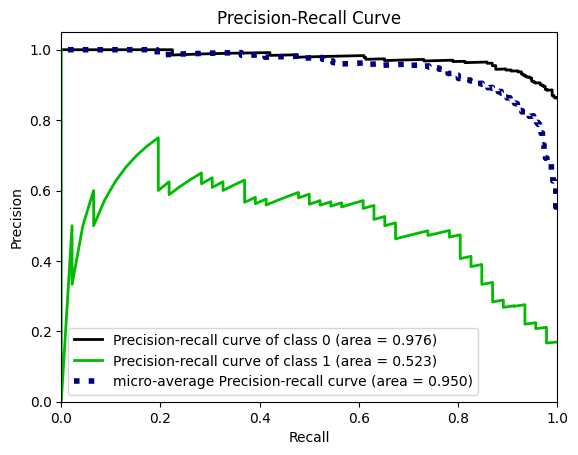

In [262]:
skplt.metrics.plot_precision_recall(y_test, y_test_pred)

In the precision-recall graphic it is possible to see the trade-off between both metrics. If we want to optimize more the model to the recall, the precision will decrease!

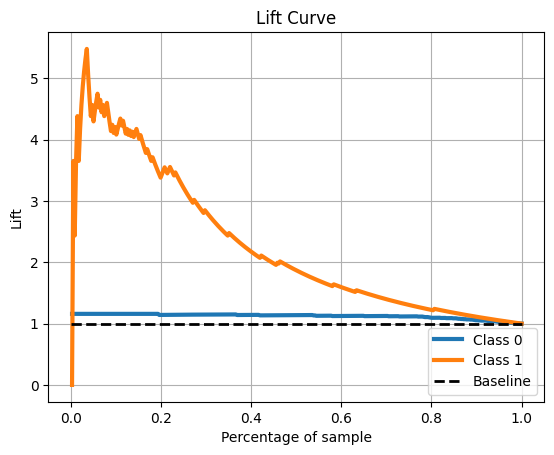

In [263]:
skplt.metrics.plot_lift_curve(y_test, y_test_pred)
plt.show()

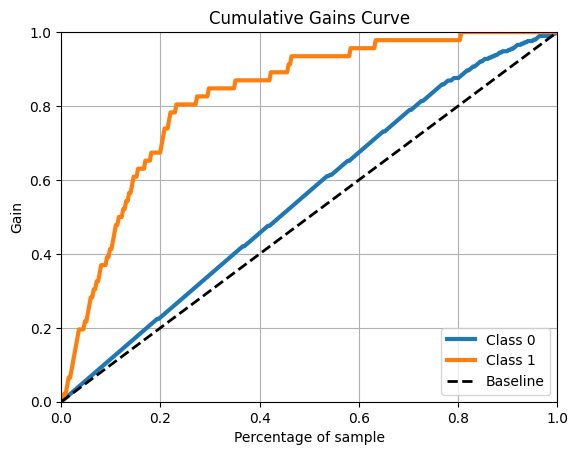

In [264]:
skplt.metrics.plot_cumulative_gain(y_test, y_test_pred)
plt.show()

The lift curve is a graphical representation of the performance of a classification model. It is often used in marketing to measure the effectiveness of campaigns and to identify segments of the population that are more likely to respond to a particular offer.

In this case, for example, if we contact 20% of our top customers given by the model, our approach is 3.5x better than the baseline, which is contact people randomly. 

To complement this analysis, we can use the cumulative gains curve. This chart shows the proportion of responders captured by the model as the proportion of the population targeted increases. In other words, it shows the cumulative response rate as more individuals are targeted.

If we analyze the graphic, it is possible to see that if we contact around 60% of the database, we already have contacted all people that will accept the new campaign. If we translate both graphics to business value, they help us to decide the size of the population that we need to send our marketing campaign, saving a lot of money!



To improve even more the metrics of the classification model, it may be necessary to get more data and new features that can help the model to distinguish between the class 1 and 0. Also, there are more 1 approache that can work: balancing the dataset with synthetic techniques such as SMOTE or other similar.

For this project, I will not explore the technique mentioned before.

### 7.0 Business Value

Since the customer cost is lower than the cost of lost a customer purchase, we want to maximize our recall. Then, we need to put our threshold very low to achieve the optimal point related to the business value.

In [265]:
y_pred_prob = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred_model = [int(p > 0.3) for p in y_pred_prob]

In [266]:
y_pred_baseline = y_baseline_test

In [267]:
comparison_test = pd.DataFrame({'y_true': y_test, 'y_pred_model': y_pred_model})
comparison_test['y_baseline'] = y_pred_baseline

comparison_test

,y_true,y_pred_model,y_baseline
2237,0,0,0
1374,0,0,0
1844,0,0,0
1187,0,0,0
1251,0,0,0
...,...,...,...
1054,0,0,0
1177,0,0,0
758,0,0,0
218,0,0,0


In [268]:
comparison_test = pd.concat([X_test['amount_spent_month'], comparison_test], axis = 1)
comparison_test

,amount_spent_month,y_true,y_pred_model,y_baseline
2237,235.548387,0,0,0
1374,54.844720,0,0,0
1844,56.470588,0,0,0
1187,97.402597,0,0,0
1251,82.931034,0,0,0
...,...,...,...,...
1054,1.800000,0,0,0
1177,32.720588,0,0,0
758,4.394904,0,0,0
218,21.754967,0,0,0


In [269]:
cost_per_customer = 5

# Model Results
true_customer_detect_amount = comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_pred_model'] == 1)]['amount_spent_month'].sum()
number_true_customer = len(comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_pred_model'] == 1)])

false_customer_detect_amount = comparison_test[(comparison_test['y_true'] == 0) & (comparison_test['y_pred_model'] == 1)]['y_true'].count() * cost_per_customer
number_false_customer = len(comparison_test[(comparison_test['y_true'] == 0) & (comparison_test['y_pred_model'] == 1)])

lost_amount = comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_pred_model'] == 0)]['amount_spent_month'].sum()
number_lost = len(comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_pred_model'] == 0)])

model_results = true_customer_detect_amount - false_customer_detect_amount - lost_amount

print(f'The marketing campaign for the next month, using the model, should return $ {round(model_results, 2)}')

# Baseline Results
true_customer_detect_amount = comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_baseline'] == 1)]['amount_spent_month'].sum()
number_true_customer = len(comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_baseline'] == 1)])

false_customer_detect_amount = comparison_test[(comparison_test['y_true'] == 0) & (comparison_test['y_baseline'] == 1)]['y_true'].count() * cost_per_customer
number_false_customer = len(comparison_test[(comparison_test['y_true'] == 0) & (comparison_test['y_baseline'] == 1)])

lost_amount = comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_baseline'] == 0)]['amount_spent_month'].sum()
number_lost = len(comparison_test[(comparison_test['y_true'] == 1) & (comparison_test['y_baseline'] == 0)])

baseline_results = true_customer_detect_amount - false_customer_detect_amount - lost_amount


print(f'The marketing campaign for the next month, using the baseline, should return $ {round(baseline_results, 2)}')



The marketing campaign for the next month, using the model, should return $ 3092.32
The marketing campaign for the next month, using the baseline, should return $ -4801.94
